<h1 style="text-align:center; color:#191970; font-weight:bold;">Value at Risk (VaR) as a Tool for Market Risk Assessment: Lessons from Historical Financial Crises</h1>

Import necessary libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import yfinance as yf
import os
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

In [21]:
sns.set_style("whitegrid")

plt.rc("figure", figsize=(16, 8))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

<h2 style="color:#191970; font-weight:bold;">Methodology: A 3 Phase Framework</h2>

## <span style="color:darkred; font-weight:bold;">Phase 1: Data Preprocessing and Simulation Creation</span>


### Data Collection

In [22]:
tickers = ['^GDAXI', '^GSPC', '^HSI']
start_date = '2007-01-01'
end_date = '2009-01-01'

data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  3 of 3 completed


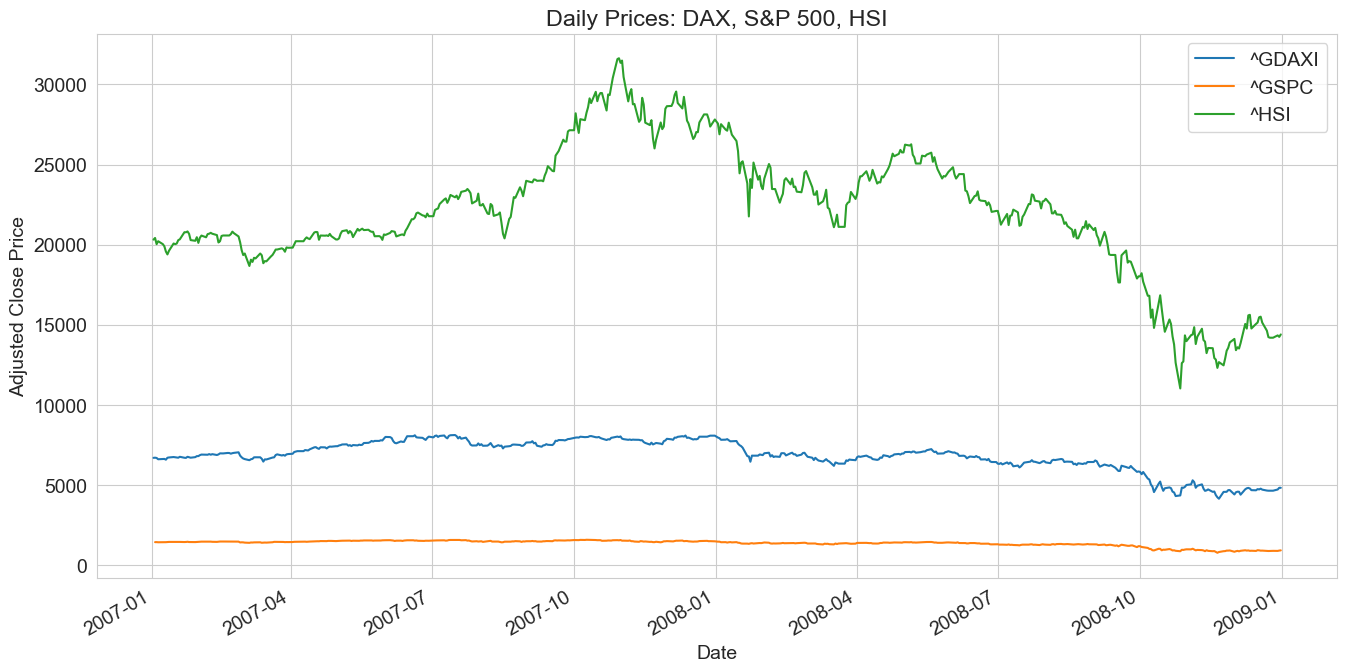

In [23]:
prices = data['Adj Close'].copy()

# Forward fill missing values
prices.ffill(inplace=True)

# Plotting the prices
prices.plot()
plt.title('Daily Prices: DAX, S&P 500, HSI')
plt.ylabel('Adjusted Close Price')
plt.show()

### Log Returns Transformation

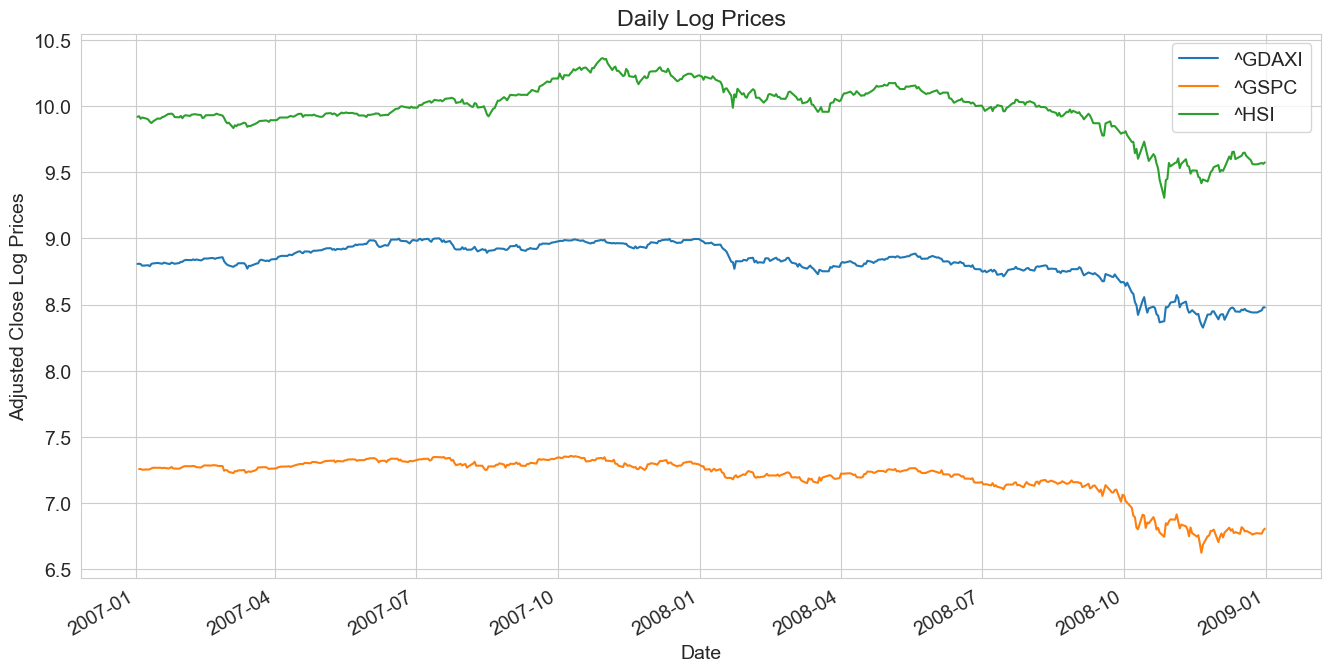

In [24]:
np.log(prices).plot()
plt.ylabel('Adjusted Close Log Prices')
plt.title('Daily Log Prices')
plt.show()

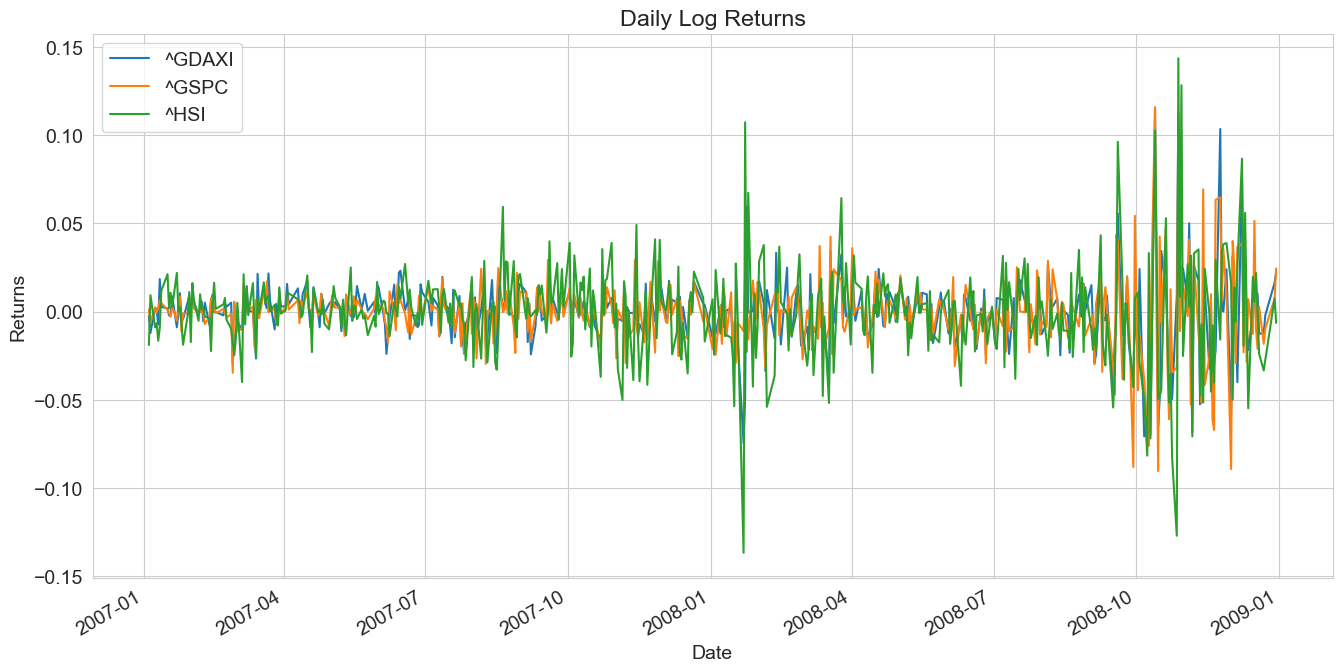

In [25]:
returns = data['Adj Close'].dropna().pct_change()
squared_returns = returns ** 2

returns.plot()
plt.title('Daily Log Returns')
plt.ylabel('Returns')
plt.savefig('Daily_returns.png')  
plt.show()

In [26]:
returns_summary = (returns*100).describe()
returns_summary.round(2)[1:]

,^GDAXI,^GSPC,^HSI
mean,-0.05,-0.08,-0.04
std,1.91,2.02,2.65
min,-7.45,-9.03,-13.67
25%,-0.81,-0.89,-1.33
50%,0.05,0.03,0.07
75%,0.84,0.69,1.19
max,11.40,11.58,14.35


In [27]:
# Transfer summary statistics table into latex (dissertation specific)
returns_summary = (returns*100).describe()
latex_table = returns_summary.round(2).to_latex()
print(latex_table)

\begin{tabular}{lrrr}
\toprule
 & ^GDAXI & ^GSPC & ^HSI \\
\midrule
count & 474.000000 & 474.000000 & 474.000000 \\
mean & -0.050000 & -0.080000 & -0.040000 \\
std & 1.910000 & 2.020000 & 2.650000 \\
min & -7.450000 & -9.030000 & -13.670000 \\
25% & -0.810000 & -0.890000 & -1.330000 \\
50% & 0.050000 & 0.030000 & 0.070000 \\
75% & 0.840000 & 0.690000 & 1.190000 \\
max & 11.400000 & 11.580000 & 14.350000 \\
\bottomrule
\end{tabular}



In [28]:
data

Adj Close                                   Close               \
                 ^GDAXI        ^GSPC          ^HSI       ^GDAXI        ^GSPC   
Date                                                                           
2007-01-02  6681.129883          NaN  20310.179688  6681.129883          NaN   
2007-01-03  6691.319824  1416.599976  20413.390625  6691.319824  1416.599976   
2007-01-04  6674.399902  1418.339966  20025.580078  6674.399902  1418.339966   
2007-01-05  6593.089844  1409.709961  20211.279297  6593.089844  1409.709961   
2007-01-08  6607.589844  1412.839966  20029.660156  6607.589844  1412.839966   
...                 ...          ...           ...          ...          ...   
2008-12-24          NaN   868.150024  14184.139648          NaN   868.150024   
2008-12-26          NaN   872.799988           NaN          NaN   872.799988   
2008-12-29  4704.859863   869.419983  14328.480469  4704.859863   869.419983   
2008-12-30  4810.200195   890.640015  14235.500000  4810.200195   890.640015   
2008-12-31          NaN   903.250000  14387.480469          NaN   903.250000   

                                 High                                     Low  \
                    ^HSI       ^GDAXI        ^GSPC          ^HSI       ^GDAXI   
Date                                                                            
2007-01-02  20310.179688  6682.810059          NaN  20323.589844  6614.729980   
2007-01-03  20413.390625  6704.040039  1429.420044  20554.580078  6667.580078   
2007-01-04  20025.580078  6684.109863  1421.839966  20463.179688  6634.740234   
2007-01-05  20211.279297  6665.509766  1418.339966  20213.640625  6588.029785   
2007-01-08  20029.660156  6628.359863  1414.979980  20085.580078  6579.899902   
...                  ...          ...          ...           ...          ...   
2008-12-24  14184.139648          NaN   869.789978  14300.700195          NaN   
2008-12-26           NaN          NaN   873.739990           NaN          NaN   
2008-12-29  14328.480469  4732.850098   873.700012  14332.019531  4655.910156   
2008-12-30  14235.500000  4810.410156   891.119995  14513.480469  4754.220215   
2008-12-31  14387.480469          NaN   910.320007  14527.099609          NaN   

                                              Open                             \
                  ^GSPC          ^HSI       ^GDAXI        ^GSPC          ^HSI   
Date                                                                            
2007-01-02          NaN  19990.279297  6614.729980          NaN  20004.839844   
2007-01-03  1407.859985  20249.609375  6681.229980  1418.030029  20353.419922   
2007-01-04  1408.430054  19948.019531  6662.240234  1416.599976  20415.669922   
2007-01-05  1405.750000  19757.240234  6661.899902  1418.339966  19890.150391   
2007-01-08  1403.969971  19844.310547  6603.549805  1409.260010  19915.000000   
...                 ...           ...          ...          ...           ...   
2008-12-24   861.440002  13855.889648          NaN   863.869995  13855.889648   
2008-12-26   866.520020           NaN          NaN   869.510010           NaN   
2008-12-29   857.070007  13924.320312  4660.169922   872.369995  14080.860352   
2008-12-30   870.580017  14189.080078  4754.220215   870.580017  14476.740234   
2008-12-31   889.669983  14302.150391          NaN   890.590027  14377.509766   

                 Volume                              
                 ^GDAXI         ^GSPC          ^HSI  
Date                                                 
2007-01-02   70947800.0           NaN  1.264597e+09  
2007-01-03  105913800.0  3.429160e+09  1.673969e+09  
2007-01-04  143461600.0  3.004460e+09  2.130510e+09  
2007-01-05  142562500.0  2.919400e+09  1.959114e+09  
2007-01-08  116670200.0  2.763340e+09  1.438589e+09  
...                 ...           ...           ...  
2008-12-24          NaN  1.546550e+09  8.654987e+08  
2008-12-26          NaN  1.880050e+09           NaN  
2008-12-29  100697000.0  3.32

### EHS VaR (Student's t-distribution)

In [29]:
confidence_level = 0.95
time_horizon = 1
common_degrees_of_freedom = 5  #The lower the DF (v), the fatter the tails 

var_results_list = []

#'returns' is the DataFrame containing my log returns
for index_name in returns.columns:
    var = stats.t.ppf(1 - confidence_level, common_degrees_of_freedom, 
                      loc=returns[index_name].mean(), 
                      scale=returns[index_name].std())
    var_results_list.append({'tickers': index_name, 'VaR': var})

# Create DataFrame from the list
var_results = pd.DataFrame(var_results_list)

# Check for NaN values
if var_results.isnull().values.any():
    print("Warning: NaN values detected in the result.")

print(var_results)

  tickers       VaR
0  ^GDAXI -0.038911
1   ^GSPC -0.041432
2    ^HSI -0.053803


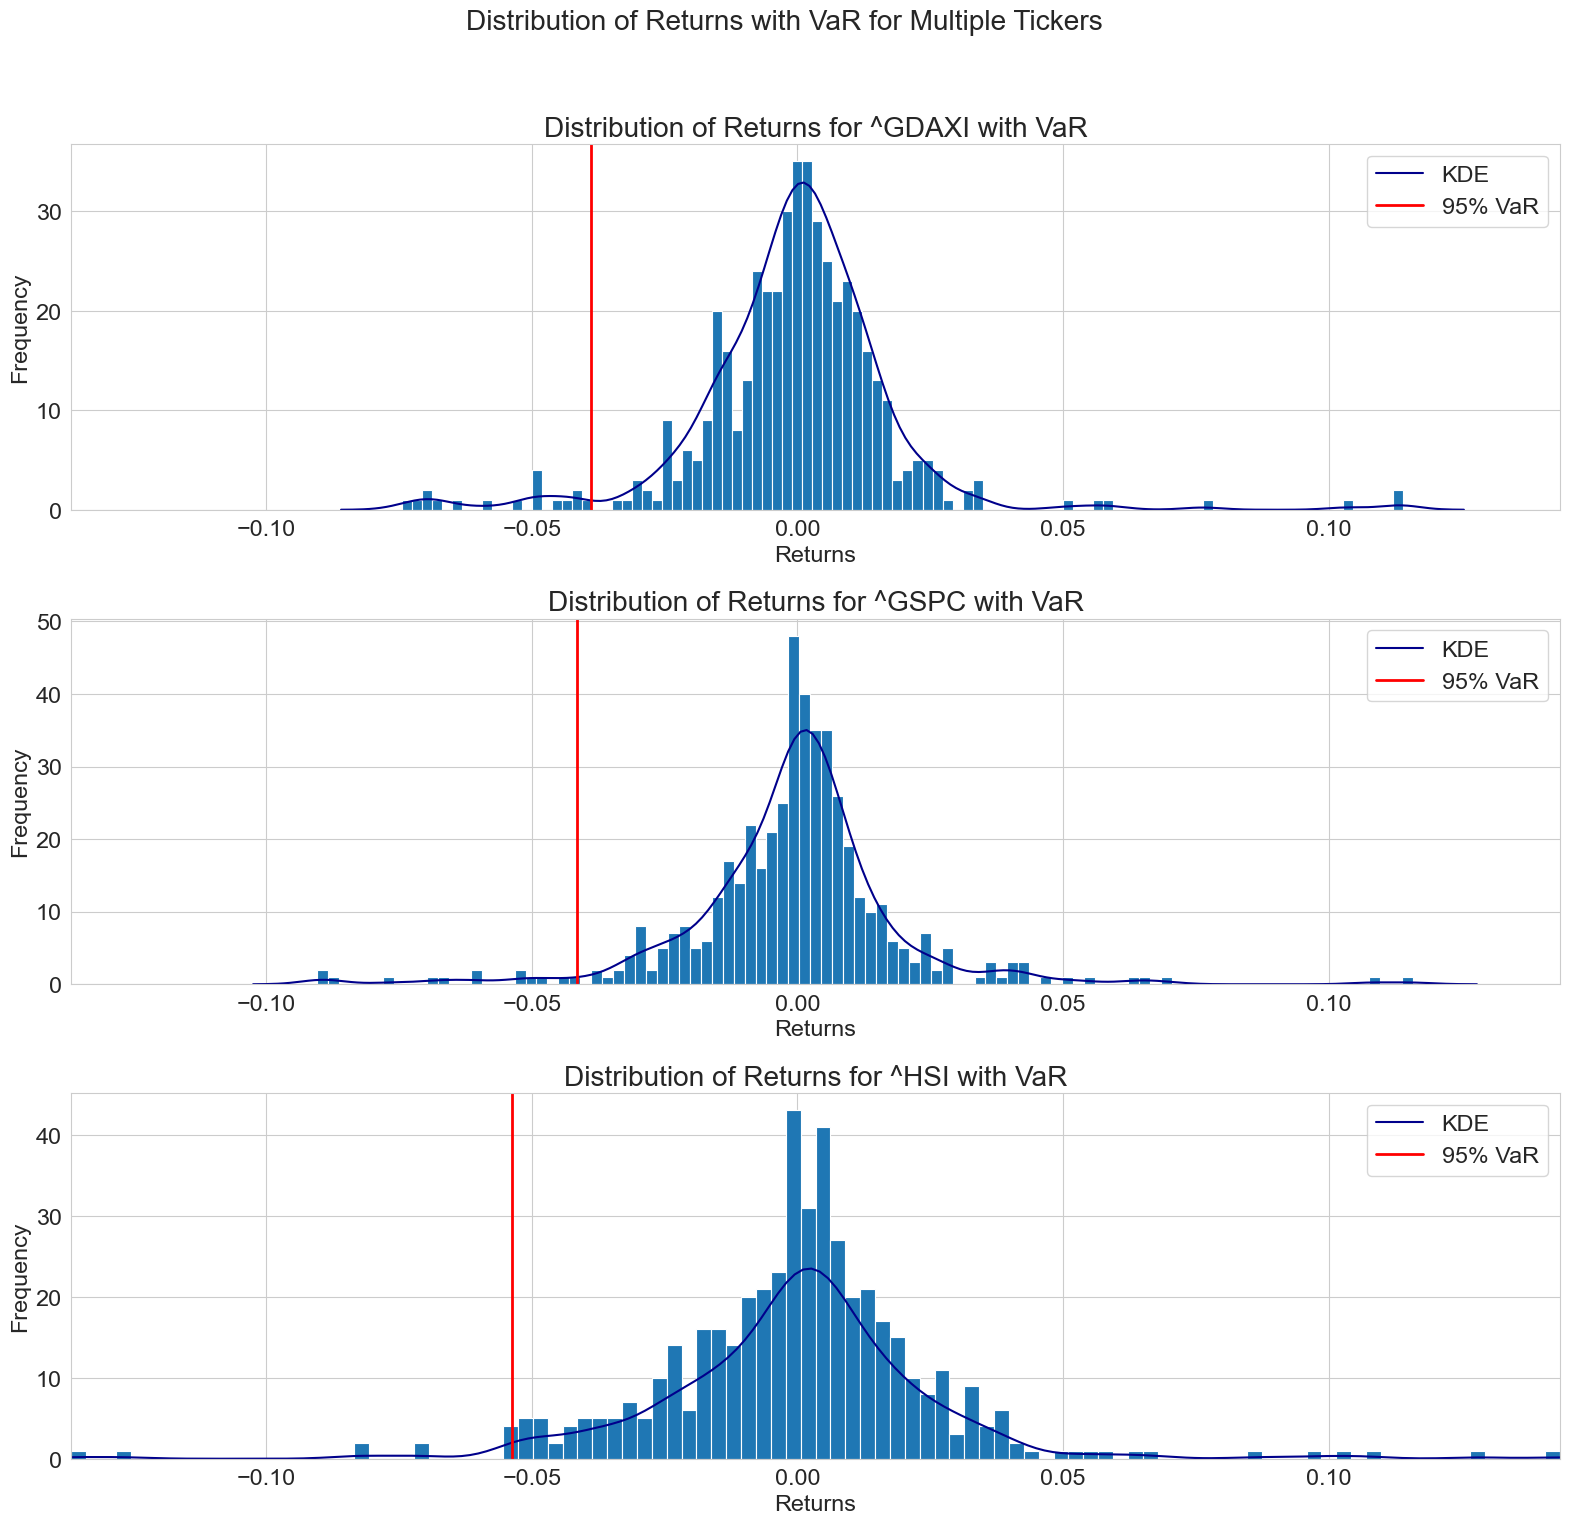

In [30]:
plt.rcParams.update({'font.size': 16.8})

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 15))

# Get the overall minimum and maximum values of log returns across all tickers
min_return = returns.min().min()
max_return = returns.max().max()

# Plot distribution with KDE for each ticker in a subplot
for i, index_name in enumerate(returns.columns):
    sns.histplot(returns[index_name], color='#1f77b4', bins=100, ax=axes[i], alpha=1, kde_kws={'bw_method': 25})  # Specifying bandwidth for histplot

    # Create a separate KDE plot 
    sns.kdeplot(returns[index_name], color='darkblue', ax=axes[i], label='KDE', bw_method=0.2)  # Specifying bandwidth for kdeplot
    
    axes[i].axvline(var_results[var_results['tickers'] == index_name]['VaR'].iloc[0], color='red', linestyle='solid', linewidth=2, label='95% VaR')
    axes[i].set_title(f'Distribution of Returns for {index_name} with VaR')
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(min_return, max_return)  
    axes[i].legend()

fig.suptitle('Distribution of Returns with VaR for Multiple Tickers', y=1.02)

plt.tight_layout()

plt.savefig('Distribution_of_Returns_with_VaR.png')

plt.show()

#### Distribution Analysis (Skewness and Kurtosis)

In [31]:
# Calculate skewness and kurtosis for each distribution of returns
skewness_list = []
kurtosis_list = []

for index_name in returns.columns:
    skewness = np.nan_to_num(np.mean((returns[index_name] - np.mean(returns[index_name])) ** 3) / np.std(returns[index_name]) ** 3)
    kurtosis = np.nan_to_num(np.mean((returns[index_name] - np.mean(returns[index_name])) ** 4) / np.std(returns[index_name]) ** 4 - 3)
    print(f"Stock Index: {index_name}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    print("------------------------")

Stock Index: ^GDAXI
Skewness: 0.6125017944737496
Kurtosis: 8.951562767402592
------------------------
Stock Index: ^GSPC
Skewness: 0.07918943126212516
Kurtosis: 7.038004649612928
------------------------
Stock Index: ^HSI
Skewness: 0.21325875219746432
Kurtosis: 6.158202014958189
------------------------


#### Jarque Bera Test and ADF

In [32]:
for index_name in returns.columns:
    # Jarque-Bera test
    jb_test_stat, jb_p_value = stats.jarque_bera(returns[index_name].dropna())
    print(f"Jarque-Bera test for {index_name}:")
    print(f"Test statistic: {jb_test_stat}")
    print(f"P-value: {jb_p_value}")
    if jb_p_value < 0.05:
        print("The null hypothesis (normality) is rejected.")
    else:
        print("The null hypothesis (normality) cannot be rejected.")
    print("------------------------")

Jarque-Bera test for ^GDAXI:
Test statistic: 1612.2144179907314
P-value: 0.0
The null hypothesis (normality) is rejected.
------------------------
Jarque-Bera test for ^GSPC:
Test statistic: 978.782217913335
P-value: 2.8849738940536488e-213
The null hypothesis (normality) is rejected.
------------------------
Jarque-Bera test for ^HSI:
Test statistic: 752.5810424621602
P-value: 3.794049885473423e-164
The null hypothesis (normality) is rejected.
------------------------


In [33]:
for index_name in returns.columns:
# Augmented Dickey-Fuller (ADF) test
    adf_test_result = adfuller(returns[index_name].dropna(), autolag='AIC')
    print(f"ADF test for {index_name}:")
    print(f"ADF Statistic: {adf_test_result[0]}")
    print(f"P-value: {adf_test_result[1]}")
    print("Critical Values:")
    for key, value in adf_test_result[4].items():
        print(f"\t{key}: {value}")
    if adf_test_result[1] < 0.05:
        print("The null hypothesis (unit root) is rejected; data is stationary.")
    else:
        print("The null hypothesis (unit root) cannot be rejected; data may not be stationary.")
    print("------------------------")

ADF test for ^GDAXI:
ADF Statistic: -5.019224198009573
P-value: 2.032886490110016e-05
Critical Values:
	1%: -3.4448040131772584
	5%: -2.8679131843980197
	10%: -2.5701646673107112
The null hypothesis (unit root) is rejected; data is stationary.
------------------------
ADF test for ^GSPC:
ADF Statistic: -5.795048911410858
P-value: 4.773518674053266e-07
Critical Values:
	1%: -3.444740396477859
	5%: -2.8678852001919073
	10%: -2.570149751878151
The null hypothesis (unit root) is rejected; data is stationary.
------------------------
ADF test for ^HSI:
ADF Statistic: -12.59301505980646
P-value: 1.803862031973171e-23
Critical Values:
	1%: -3.4443401584716296
	5%: -2.867709127168354
	10%: -2.5700559076505205
The null hypothesis (unit root) is rejected; data is stationary.
------------------------


## <span style="color:darkred; font-weight:bold;">Phase 2: Model Sensitivity and Backtesting</span>

### Sensitivity Testing

#### Sensitivity Analysis: Confidence Level

In [34]:
def calculate_var(returns, confidence_level=0.95, time_horizon=1, degrees_of_freedom=5):
    var_results_list = []

    for index_name in returns.columns:
        var = stats.t.ppf(1 - confidence_level, degrees_of_freedom,
                          loc=returns[index_name].mean(),
                          scale=returns[index_name].std())
        var_results_list.append({'tickers': index_name, 'VaR': var})

    var_results = pd.DataFrame(var_results_list)

    # Check for NaN values
    if var_results.isnull().values.any():
        print("Warning: NaN values detected in the result.")

    return var_results

# Original calculation of Var (Default parameters)
confidence_level_original = 0.95
time_horizon_original = 1
common_degrees_of_freedom = 5

var_results_original = calculate_var(returns, confidence_level_original, time_horizon_original, common_degrees_of_freedom)
print("Original results:")
print(var_results_original)

# Sensitivity analysis with different confidence levels (90% and 99%)
confidence_levels = [0.90, 0.99]

for level in confidence_levels:
    var_results_sensitivity = calculate_var(returns, confidence_level=level, time_horizon=time_horizon_original, degrees_of_freedom=common_degrees_of_freedom)
    print(f"Results for confidence level {level}:")
    print(var_results_sensitivity)

Original results:
  tickers       VaR
0  ^GDAXI -0.038911
1   ^GSPC -0.041432
2    ^HSI -0.053803
Results for confidence level 0.9:
  tickers       VaR
0  ^GDAXI -0.028638
1   ^GSPC -0.030553
2    ^HSI -0.039517
Results for confidence level 0.99:
  tickers       VaR
0  ^GDAXI -0.064632
1   ^GSPC -0.068668
2    ^HSI -0.089571


#### Sensitivity Analysis: Time Horizon

In [35]:
common_confidence_level = 0.95
common_degrees_of_freedom = 5 

time_horizons = [1, 5, 21]  #Different time horizons to analyze (Default at 1 day, testing 5-day and 21-day time horizons)
# Create Dataframe
var_results_list = []

for time_horizon in time_horizons:
    temp_var_results = []

    for index_name in returns.columns:
        var = stats.t.ppf(1 - common_confidence_level, common_degrees_of_freedom, 
                          loc=returns[index_name].mean(), 
                          scale=returns[index_name].std() * (time_horizon ** 0.5))
        temp_var_results.append({'tickers': index_name, 'VaR': var, 'Time Horizon': time_horizon})

    var_results_list.extend(temp_var_results)

# Create DataFrame from the list
var_results = pd.DataFrame(var_results_list)

# Check for NaN values
if var_results.isnull().values.any():
    print("Warning: NaN values detected in the result.")

print(var_results)

  tickers       VaR  Time Horizon
0  ^GDAXI -0.038911             1
1   ^GSPC -0.041432             1
2    ^HSI -0.053803             1
3  ^GDAXI -0.086370             5
4   ^GSPC -0.091686             5
5    ^HSI -0.119801             5
6  ^GDAXI -0.176465            21
7   ^GSPC -0.187088            21
8    ^HSI -0.245088            21


### Time Series Plot

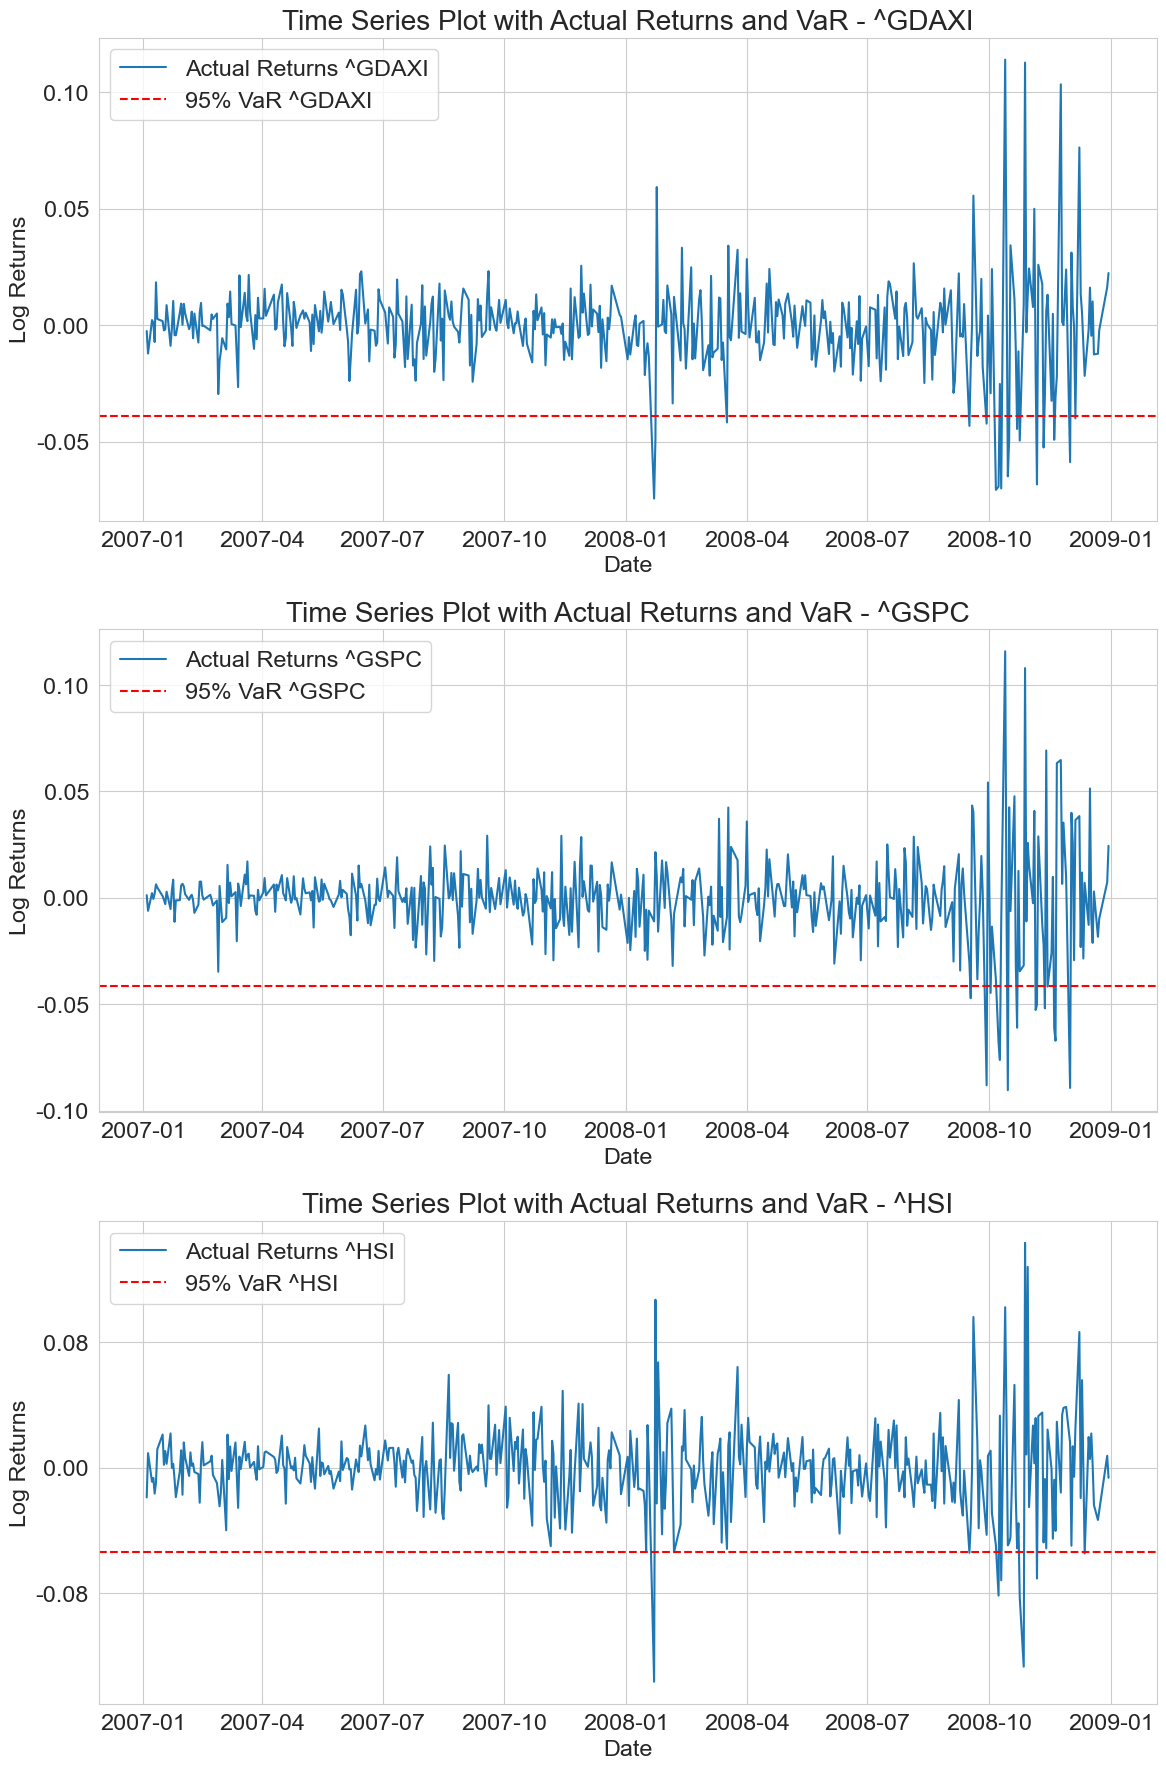

In [36]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

# Create a single figure of all 3 stocks
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plotting actual log returns and VaR for each index
for i, index_name in enumerate(returns.columns):
    
    # Actual log returns
    axes[i].plot(returns.index, returns[index_name], label=f'Actual Returns {index_name}')
    
    # VaR line
    axes[i].axhline(var_results[var_results['tickers'] == index_name]['VaR'].iloc[0],
                    linestyle='dashed', color='red', label=f'95% VaR {index_name}')

    axes[i].set_title(f'Time Series Plot with Actual Returns and VaR - {index_name}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Log Returns')

    # Setting y-axis ticks to 2 decimal places
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
    

    axes[i].legend()

plt.tight_layout()

plt.savefig('Time_Series_Plot_All.png')

plt.show()

### Backtesting

#### Exceedance Test

In [37]:
# Create an empty list to store exceedance count results
exceedance_results = []

# Exceedance count test
for index_name in returns.columns:
    va_r = var_results[var_results['tickers'] == index_name]['VaR'].iloc[0]
    exceedances = returns[returns[index_name] < va_r]
    num_exceedances = len(exceedances)

    # Append results to the list
    exceedance_results.append({'Index': index_name, 'Exceedance Count': num_exceedances})

# Create a DataFrame from the list
exceedance_df = pd.DataFrame(exceedance_results)

print(exceedance_df)

    Index  Exceedance Count
0  ^GDAXI                17
1   ^GSPC                14
2    ^HSI                 9


#### Kupiec Test

The Kupiec Test was performed in Excel outside of this environment. This was necessitated by issues related to the Python 3.12 version, which lacked the 'vartests' packages required for conducting the test.

In [38]:
output_folder = 'returns_excel_files/'
os.makedirs(output_folder, exist_ok=True)

# Export returns data for each stock index to a separate Excel file
for index_name in returns.columns:
    returns_data = pd.DataFrame({'Date': returns.index, 'Returns': returns[index_name]})
    excel_filename = f'{output_folder}{index_name}_returns.xlsx'
    returns_data.to_excel(excel_filename, index=False)
    print(f"Returns data for {index_name} exported to {excel_filename}")

Returns data for ^GDAXI exported to returns_excel_files/^GDAXI_returns.xlsx
Returns data for ^GSPC exported to returns_excel_files/^GSPC_returns.xlsx
Returns data for ^HSI exported to returns_excel_files/^HSI_returns.xlsx
